In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/zillow/City_time_series.csv')

# Display basic info
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 2 rows:")
print(df.head(5))

Shape: (3762566, 81)

Columns: ['Date', 'RegionName', 'InventorySeasonallyAdjusted_AllHomes', 'InventoryRaw_AllHomes', 'MedianListingPricePerSqft_1Bedroom', 'MedianListingPricePerSqft_2Bedroom', 'MedianListingPricePerSqft_3Bedroom', 'MedianListingPricePerSqft_4Bedroom', 'MedianListingPricePerSqft_5BedroomOrMore', 'MedianListingPricePerSqft_AllHomes', 'MedianListingPricePerSqft_CondoCoop', 'MedianListingPricePerSqft_DuplexTriplex', 'MedianListingPricePerSqft_SingleFamilyResidence', 'MedianListingPrice_1Bedroom', 'MedianListingPrice_2Bedroom', 'MedianListingPrice_3Bedroom', 'MedianListingPrice_4Bedroom', 'MedianListingPrice_5BedroomOrMore', 'MedianListingPrice_AllHomes', 'MedianListingPrice_CondoCoop', 'MedianListingPrice_DuplexTriplex', 'MedianListingPrice_SingleFamilyResidence', 'MedianPctOfPriceReduction_AllHomes', 'MedianPctOfPriceReduction_CondoCoop', 'MedianPctOfPriceReduction_SingleFamilyResidence', 'MedianPriceCutDollar_AllHomes', 'MedianPriceCutDollar_CondoCoop', 'MedianPriceCut

In [2]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Basic temporal and geographic stats
print("Date range:", df['Date'].min(), "to", df['Date'].max())
print("Number of unique cities (RegionName):", df['RegionName'].nunique())
print("Total rows:", len(df))

# Check % of missing values in key target columns
key_cols = ['ZHVI_AllHomes', 'MedianListingPrice_AllHomes', 'ZRI_AllHomes']
for col in key_cols:
    pct_missing = df[col].isna().mean() * 100
    print(f"% Missing in {col}: {pct_missing:.2f}%")

Date range: 1996-04-30 00:00:00 to 2017-12-31 00:00:00
Number of unique cities (RegionName): 16636
Total rows: 3762566
% Missing in ZHVI_AllHomes: 18.05%
% Missing in MedianListingPrice_AllHomes: 88.52%
% Missing in ZRI_AllHomes: 70.81%


In [3]:
# Keep only essential columns
df_clean = df[['Date', 'RegionName', 'ZHVI_AllHomes']].copy()

# Filter to years with better coverage (2010–2017)
df_clean = df_clean[(df_clean['Date'] >= '2010-01-01') & (df_clean['Date'] <= '2017-12-31')]

# Drop rows where ZHVI_AllHomes is NaN
df_clean = df_clean.dropna(subset=['ZHVI_AllHomes'])

# Keep only cities with at least 24 months of data
city_counts = df_clean['RegionName'].value_counts()
cities_with_enough_data = city_counts[city_counts >= 24].index
df_clean = df_clean[df_clean['RegionName'].isin(cities_with_enough_data)]

print("Filtered shape:", df_clean.shape)
print("Date range:", df_clean['Date'].min(), "to", df_clean['Date'].max())
print("Number of cities retained:", df_clean['RegionName'].nunique())

Filtered shape: (1245588, 3)
Date range: 2010-01-31 00:00:00 to 2017-12-31 00:00:00
Number of cities retained: 13147


In [4]:
import re

# Common 2-letter state codes (US + DC)
us_states = {
    'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'dc', 'fl', 'ga',
    'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma',
    'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny',
    'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
    'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy'
}

# Function to extract state from RegionName suffix
def extract_state(region):
    if len(region) >= 2:
        suffix2 = region[-2:].lower()
        if suffix2 in us_states:
            return suffix2.upper()
    return None

# Apply state extraction
df_clean['State'] = df_clean['RegionName'].apply(extract_state)

print("Rows with inferred state:", df_clean['State'].notna().sum())
print("Coverage: {:.2f}%".format(df_clean['State'].notna().mean() * 100))
print("\nTop inferred states:")
print(df_clean['State'].value_counts().head(10))

Rows with inferred state: 1245588
Coverage: 100.00%

Top inferred states:
State
PA    130556
NY     92268
CA     68154
OH     61590
NJ     55500
IL     55151
FL     52427
MI     52090
WI     43978
IN     38781
Name: count, dtype: int64


In [5]:
# Filter to target states
target_states = ['CA', 'TX', 'FL']
df_filtered = df_clean[df_clean['State'].isin(target_states)].copy()

# Aggregate to state-monthly median
state_monthly = df_filtered.groupby(['State', df_filtered['Date'].dt.to_period('M')])['ZHVI_AllHomes'].median()
state_monthly = state_monthly.reset_index()
state_monthly['Date'] = state_monthly['Date'].dt.to_timestamp()

# Rename columns to Prophet-friendly format
state_monthly = state_monthly.rename(columns={'Date': 'ds', 'ZHVI_AllHomes': 'y'})

print("Final state-level dataset shape:", state_monthly.shape)
print("\nRows per state:")
print(state_monthly['State'].value_counts().sort_index())

Final state-level dataset shape: (288, 3)

Rows per state:
State
CA    96
FL    96
TX    96
Name: count, dtype: int64


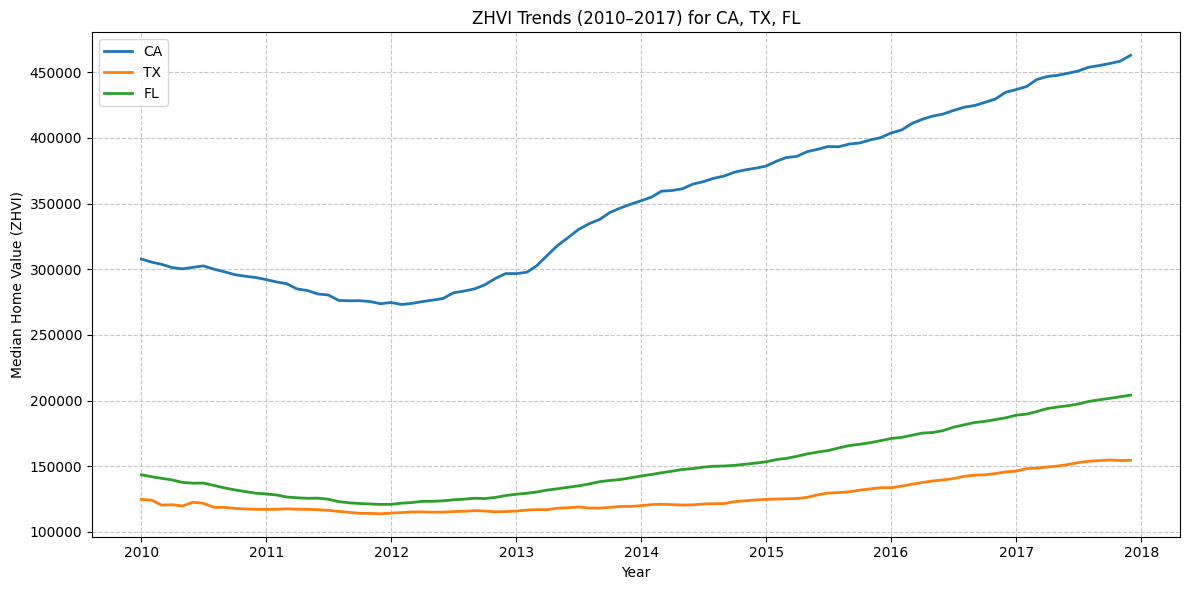

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for state in ['CA', 'TX', 'FL']:
    state_data = state_monthly[state_monthly['State'] == state]
    plt.plot(state_data['ds'], state_data['y'], label=state, linewidth=2)

plt.title('ZHVI Trends (2010–2017) for CA, TX, FL')
plt.xlabel('Year')
plt.ylabel('Median Home Value (ZHVI)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
from prophet import Prophet
import os

# Ensure output dir
os.makedirs('../data/forecasts', exist_ok=True)

# Target states
states = ['CA', 'TX', 'FL']
forecast_horizon = 12  # Forecast 12 months into 2018

all_forecasts = []

for state in states:
    print(f"\nTraining Prophet model for {state}...")
    
    # Filter data for this state
    state_data = state_monthly[state_monthly['State'] == state][['ds', 'y']].copy()
    
    # Initialize and fit Prophet
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    model.fit(state_data)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=forecast_horizon, freq='MS')
    
    # Forecast
    forecast = model.predict(future)
    forecast['State'] = state
    
    # Save forecast
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'State']].to_csv(
        f'../data/forecasts/forecast_{state}.csv', index=False
    )
    
    all_forecasts.append(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'State']])

print("\n✅ All models trained! Forecasts saved.")

c:\Users\KSEAB\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Training Prophet model for CA...


22:31:07 - cmdstanpy - INFO - Chain [1] start processing
22:31:08 - cmdstanpy - INFO - Chain [1] done processing
22:31:08 - cmdstanpy - INFO - Chain [1] start processing



Training Prophet model for TX...


22:31:10 - cmdstanpy - INFO - Chain [1] done processing
22:31:10 - cmdstanpy - INFO - Chain [1] start processing



Training Prophet model for FL...


22:31:12 - cmdstanpy - INFO - Chain [1] done processing



✅ All models trained! Forecasts saved.


In [8]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

results = []

for state in ['CA', 'TX', 'FL']:
    # Load historical data
    hist_full = state_monthly[state_monthly['State'] == state][['ds', 'y']].copy()
    hist_full['ds'] = pd.to_datetime(hist_full['ds'])
    hist_full = hist_full.set_index('ds')
    
    # Load forecast
    fcst_full = pd.read_csv(f'../data/forecasts/forecast_{state}.csv')
    fcst_full['ds'] = pd.to_datetime(fcst_full['ds'])
    fcst_full = fcst_full.set_index('ds')
    
    # Align on common dates
    common_dates = hist_full.index.intersection(fcst_full.index)
    y_true = hist_full.loc[common_dates, 'y']
    y_pred = fcst_full.loc[common_dates, 'yhat']
    
    # Compute metrics
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    results.append({
        'State': state,
        'MAPE (%)': round(mape, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4)
    })

eval_df = pd.DataFrame(results)
print("\n✅ Model Evaluation (2010–2017 Historical Fit):")
print(eval_df)


✅ Model Evaluation (2010–2017 Historical Fit):
  State  MAPE (%)     RMSE      R²
0    CA      0.24  1096.94  0.9997
1    TX      0.36   599.25  0.9977
2    FL      0.15   288.99  0.9999


In [9]:
from prophet.serialize import model_to_json
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Re-train and save models
for state in ['CA', 'TX', 'FL']:
    print(f"Saving model for {state}...")
    
    # Get data for state
    state_data = state_monthly[state_monthly['State'] == state][['ds', 'y']].copy()
    
    # Train the model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    model.fit(state_data)
    
    # ✅ Save the model as JSON
    model_path = f'../models/prophet_model_{state}.json'
    with open(model_path, "w") as fout:
        fout.write(model_to_json(model))
    
    print(f"✅ Model for {state} saved to {model_path}")

22:34:48 - cmdstanpy - INFO - Chain [1] start processing


Saving model for CA...


22:34:49 - cmdstanpy - INFO - Chain [1] done processing
22:34:49 - cmdstanpy - INFO - Chain [1] start processing


✅ Model for CA saved to ../models/prophet_model_CA.json
Saving model for TX...


22:34:50 - cmdstanpy - INFO - Chain [1] done processing
22:34:51 - cmdstanpy - INFO - Chain [1] start processing


✅ Model for TX saved to ../models/prophet_model_TX.json
Saving model for FL...


22:34:52 - cmdstanpy - INFO - Chain [1] done processing


✅ Model for FL saved to ../models/prophet_model_FL.json
